# The YT Frontend for the `QUOKKA` Dataset

## 1. Overview

[Chongchong He](https://github.com/chongchonghe) and [Rongjun Huang](https://github.com/Rongjun-ANU) have developed a new [`yt`](https://github.com/yt-project/yt) frontend for the [`QUOKKA`](https://github.com/quokka-astro/quokka) dataset, enabling seamless integration with `yt`'s data structures and visualization capabilities.

## 2. Features

### **Header Management**
- **Dynamic Field Detection**:
  - Automatically detects and loads:
    - Six mandatory gas fields (density, energy, internal energy, and x/y/z-momentum)
    - Optional fields, including temperature, scalar, radiation, and magnetic (currently a placeholder) fields 
  - **Units Management**:
    - Maps field names to (field_type, field_name) tuples, e.g., `('boxlib', 'gasDensity')` becomes `('gas', 'density')`.
    - Assigns physical units to dimensionless (or `code_unit`) native fields.

### **Metadata Management**
- Parses `Header` file for fields' information.
- Reads `metadata.yaml` for simulation parameters.
- Handles multi-dimensional data structures.

### **Particle Support**
- Dynamically detects particle types and fields from `*_particles` directories.
- Supports custom particle field units via `Fields.yaml`.

## 3. Changes

1. **`QuokkaDataset`**:
   - Modify `/yt/frontends/amrex/data_structures.py` to extend the `AMReXDataset` class:
     - Verify `QUOKKA` dataset compatibility.
     - Parse files and support additional fluid types.
2. **`QuokkaHierarchy`**:
   - Add `/yt/frontends/amrex/data_structures.py` for managing:
     - Header and metadata reading.
     - Particle information parsing.
3. **`QuokkaFieldInfo`**:
   - Add `/yt/frontends/amrex/fields.py` to manage:
     - Derived, and particle fields.
4. Import the above modules in `/yt/frontends/amrex/api.py`.

## 4. Requirements

Ensure you use the modified `yt` version available [here](https://github.com/chongchonghe/yt).

## 5. Explanation

### **5.1 Classical `QUOKKA` Dataset**

A standard `QUOKKA` dataset includes the following components:

```bash
dataset_folder/
├── Level_0/         # `QUOKKA` data
├── Header           # Dataset header information
└── metadata.yaml    # Configuration file for YT integration
```

#### **5.1.1 Metadata**
The `metadata.yaml` file is critical for `yt` to recognize a `QUOKKA` dataset. It contains parameters such as:

```yaml
a_rad: 1
c_hat: 1
c: 1
G: 1
unit_length: .nan
unit_time: .nan
unit_temperature: .nan
unit_mass: .nan
k_B: 1
```

#### **5.1.2 Particle Support**
Datasets with particles include additional directories:

```bash
dataset_folder/
├── Level_0/
├── Header
├── metadata.yaml
├── XXX_particles/     # Particle fields (e.g., Rad or Sink or CIC)
│   ├── Fields.yaml    # Particle field names and units
│   ├── Header
│   └── Level_0/
```

The `Fields.yaml` file specifies particle fields and units, expressed using four fundamental units (`M`, `L`, `T`, and `Θ` for mass, length, time and temperature).

Example `Fields.yaml`:

```yaml
velocity: [0, 1, -1, 0]
thermal_conductivity: [1, 1, -3, -1]
```

### **5.2 Loading a `QUOKKA` Dataset**

Here we load the sample data "RadBeam"

In [1]:
# Import yt and load sample data
import yt
ds = yt.load("sample/RadBeam/plt007")

yt : [INFO     ] 2025-03-15 13:10:33,395 Parameters: current_time              = 1.334256380792608e-10
yt : [INFO     ] 2025-03-15 13:10:33,396 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2025-03-15 13:10:33,397 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-15 13:10:33,398 Parameters: domain_right_edge         = [2. 2. 1.]


The easiest way to check is to print the `HydroMethod` in `ds.parameters`.

In [2]:
# Quick check
ds.parameters['HydroMethod']

'Quokka'

As expected, it returns `Quokka` rather than `boxlib` by default.  

### **5.3 Parsing Fields**

`QUOKKA` datasets always include six mandatory gas fields. These fields are represented as:
```python
[('boxlib', 'gasDensity'),
 ('boxlib', 'gasEnergy'),
 ('boxlib', 'gasInternalEnergy'),
 ('boxlib', 'x-GasMomentum'),
 ('boxlib', 'y-GasMomentum'),
 ('boxlib', 'z-GasMomentum')]
```
In practice, your dataset may include other native fields in the data object.  
You can use `ds.field_list` to display them:

In [3]:
# Native fields
ds.field_list

[('boxlib', 'gasDensity'),
 ('boxlib', 'gasEnergy'),
 ('boxlib', 'gasInternalEnergy'),
 ('boxlib', 'radEnergy-Group0'),
 ('boxlib', 'x-GasMomentum'),
 ('boxlib', 'x-RadFlux-Group0'),
 ('boxlib', 'y-GasMomentum'),
 ('boxlib', 'y-RadFlux-Group0'),
 ('boxlib', 'z-GasMomentum'),
 ('boxlib', 'z-RadFlux-Group0')]

When your dataset is loaded by `yt`, `yt` will derive some useful fields based on these native `boxlib` field, e.g., `gas`, `rad`, etc.  
You can use `ds.derived_field_list` to display them.


In [4]:
# Derived fields
ds.derived_field_list

[('boxlib', 'cell_volume'),
 ('boxlib', 'dx'),
 ('boxlib', 'dy'),
 ('boxlib', 'dz'),
 ('boxlib', 'gasDensity'),
 ('boxlib', 'gasEnergy'),
 ('boxlib', 'gasInternalEnergy'),
 ('boxlib', 'path_element_x'),
 ('boxlib', 'path_element_y'),
 ('boxlib', 'path_element_z'),
 ('boxlib', 'radEnergy-Group0'),
 ('boxlib', 'volume'),
 ('boxlib', 'x'),
 ('boxlib', 'x-GasMomentum'),
 ('boxlib', 'x-RadFlux-Group0'),
 ('boxlib', 'y'),
 ('boxlib', 'y-GasMomentum'),
 ('boxlib', 'y-RadFlux-Group0'),
 ('boxlib', 'z'),
 ('boxlib', 'z-GasMomentum'),
 ('boxlib', 'z-RadFlux-Group0'),
 ('gas', 'angular_momentum_magnitude'),
 ('gas', 'angular_momentum_x'),
 ('gas', 'angular_momentum_y'),
 ('gas', 'angular_momentum_z'),
 ('gas', 'averaged_density'),
 ('gas', 'cell_mass'),
 ('gas', 'cell_volume'),
 ('gas', 'density'),
 ('gas', 'density_gradient_magnitude'),
 ('gas', 'density_gradient_x'),
 ('gas', 'density_gradient_y'),
 ('gas', 'density_gradient_z'),
 ('gas', 'dx'),
 ('gas', 'dy'),
 ('gas', 'dynamical_time'),
 ('ga

Since all the native `boxlib` fields do not contain physical units in the dataset (`code_unit` by default), we add corresponding units to their derived counterparts. For example, when accessing the gas density field:

In [5]:
ds.r[('boxlib', 'gasDensity')]

unyt_array([1., 1., 1., ..., 1., 1., 1.], 'code_mass/code_length**3')

Derived fields are mapped with physical units by this frontend. 

In [6]:
ds.r[('gas', 'density')]

unyt_array([1., 1., 1., ..., 1., 1., 1.], 'g/cm**3')

### **5.4 Other Header and Metadata Parsing**

You can also check all the infomation from `Header` and `metadata.yaml` relevant to this data object by `ds.parameters`:

In [7]:
ds.parameters

{'plot_file_type': 'HyperCLaw-V1.1',
 'fields': ['gasDensity',
  'x-GasMomentum',
  'y-GasMomentum',
  'z-GasMomentum',
  'gasEnergy',
  'gasInternalEnergy',
  'radEnergy-Group0',
  'x-RadFlux-Group0',
  'y-RadFlux-Group0',
  'z-RadFlux-Group0'],
 'radiation_field_groups': 1,
 'dimensionality': 2,
 'current_time': 1.334256380792608e-10,
 'refinement_level': 2,
 'domain_left_edge': [0.0, 0.0],
 'domain_right_edge': [2.0, 2.0],
 'grid_info': '((0,0) (127,127) (0,0)) ((0,0) (255,255) (0,0)) ((0,0) (511,511) (0,0))',
 'timestamp': [854, 1708, 3416],
 'grid_sizes': [[0.015625, 0.015625],
  [0.0078125, 0.0078125],
  [0.00390625, 0.00390625]],
 'refinement_details': [{'level': 0,
   'num_boxes': 1,
   'current_time': 1.334256380792608e-10,
   'timestamp': 854,
   'boxes': [{'axis_0': {'left_edge': 0.0, 'right_edge': 2.0},
     'axis_1': {'left_edge': 0.0, 'right_edge': 2.0}}]},
  {'level': 1,
   'num_boxes': 12,
   'current_time': 1.334256380792608e-10,
   'timestamp': 1708,
   'boxes': [{'ax

### **5.5 Visualizations**

With this `QUOKKA` frontend integration, you can use the full range of visualization capabilities provided by `yt`. Below are examples demonstrating different visualization techniques using our sample dataset:

- Basic slice plots of gas density
- Radiation energy density visualization
- Combined plots with particle annotations

yt : [INFO     ] 2025-03-15 13:10:33,790 Parameters: current_time              = 1.334256380792608e-10
yt : [INFO     ] 2025-03-15 13:10:33,791 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2025-03-15 13:10:33,792 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-15 13:10:33,792 Parameters: domain_right_edge         = [2. 2. 1.]
yt : [INFO     ] 2025-03-15 13:10:34,054 xlim = 0.000000 2.000000
yt : [INFO     ] 2025-03-15 13:10:34,055 ylim = 0.000000 2.000000
yt : [INFO     ] 2025-03-15 13:10:34,057 xlim = 0.000000 2.000000
yt : [INFO     ] 2025-03-15 13:10:34,058 ylim = 0.000000 2.000000
yt : [INFO     ] 2025-03-15 13:10:34,065 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



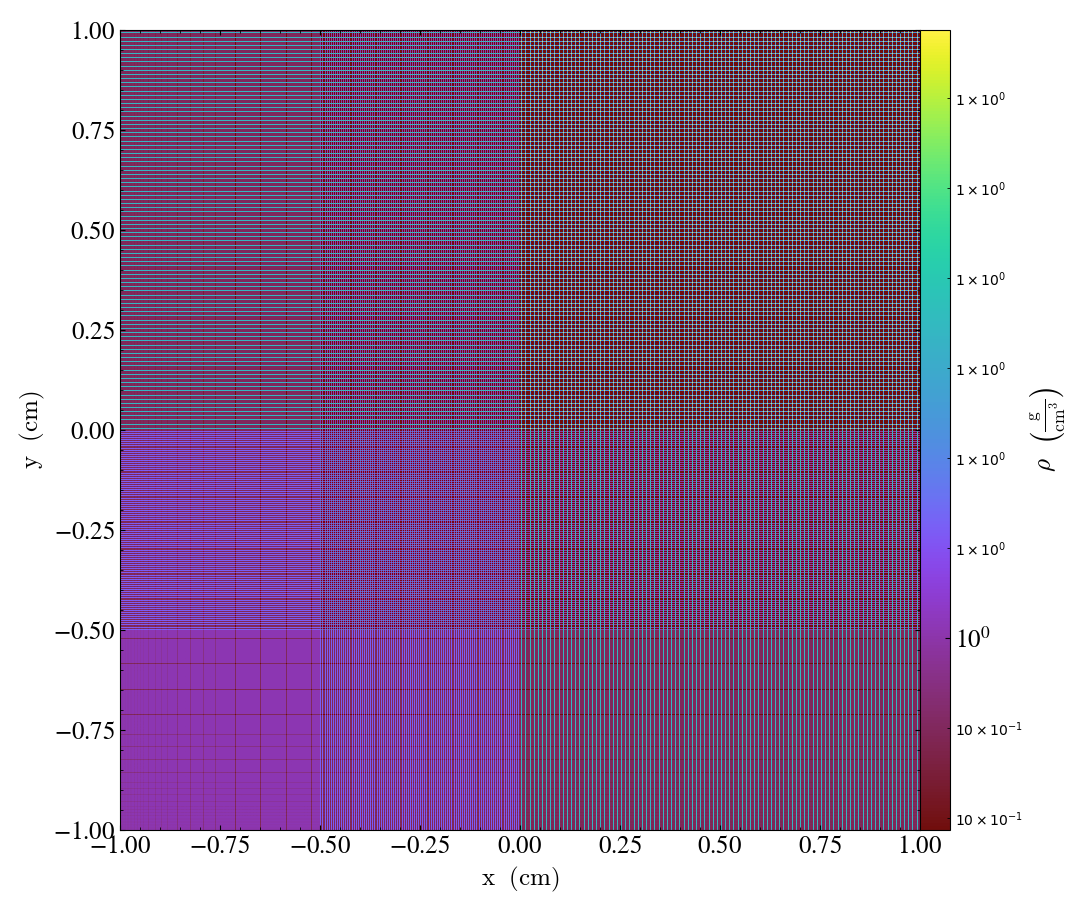

In [8]:
ds = yt.load("sample/RadBeam/plt007")
yt.SlicePlot(ds, 'z', ('gas', 'density'))

yt : [INFO     ] 2025-03-15 13:10:34,903 Parameters: current_time              = 1.334256380792608e-10
yt : [INFO     ] 2025-03-15 13:10:34,904 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2025-03-15 13:10:34,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-15 13:10:34,905 Parameters: domain_right_edge         = [2. 2. 1.]


yt : [INFO     ] 2025-03-15 13:10:35,162 xlim = 0.000000 2.000000
yt : [INFO     ] 2025-03-15 13:10:35,163 ylim = 0.000000 2.000000
yt : [INFO     ] 2025-03-15 13:10:35,165 xlim = 0.000000 2.000000
yt : [INFO     ] 2025-03-15 13:10:35,165 ylim = 0.000000 2.000000
yt : [INFO     ] 2025-03-15 13:10:35,167 Making a fixed resolution buffer of (('rad', 'energy_density_0')) 800 by 800



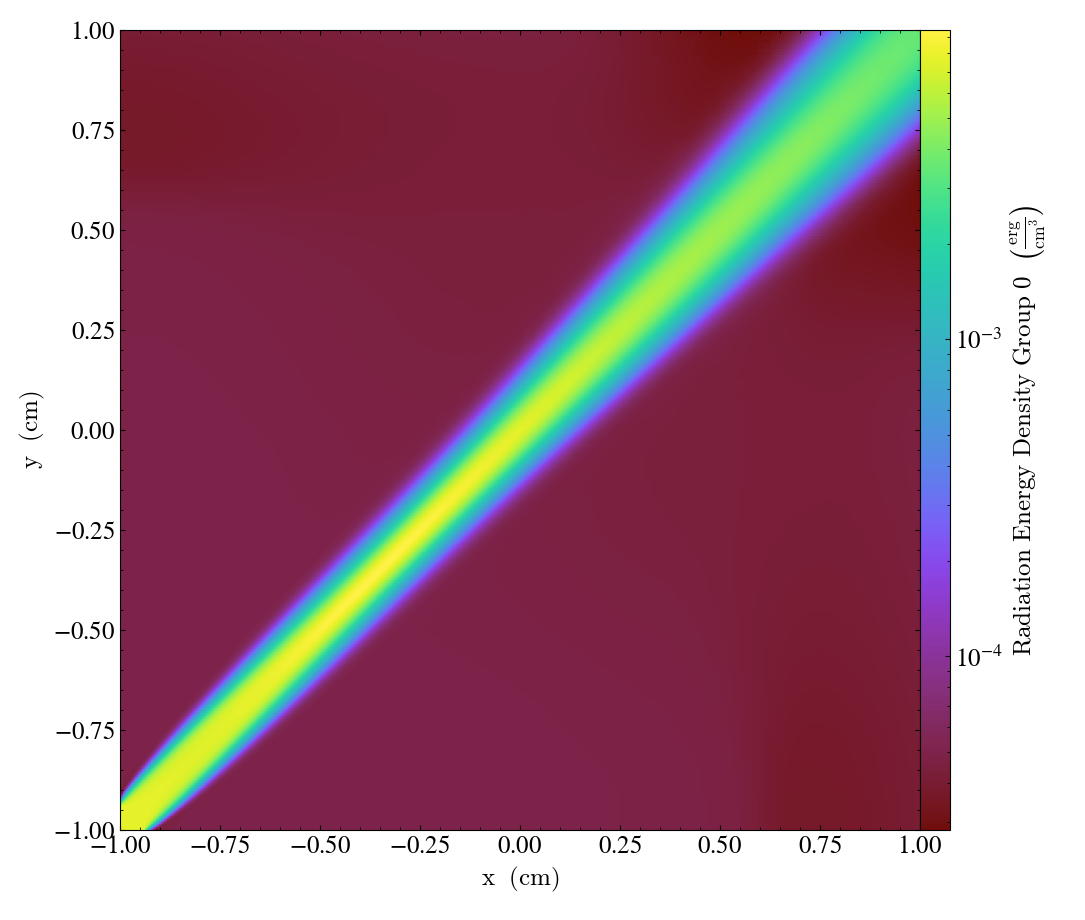

In [9]:
ds = yt.load("sample/RadBeam/plt007")
yt.SlicePlot(ds, 'z', ('rad', 'energy_density_0'))

yt : [INFO     ] 2025-03-15 13:10:35,812 Parameters: current_time              = 0.15000000000000002
yt : [INFO     ] 2025-03-15 13:10:35,813 Parameters: domain_dimensions         = [64 64  1]
yt : [INFO     ] 2025-03-15 13:10:35,814 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-15 13:10:35,815 Parameters: domain_right_edge         = [1. 1. 1.]


yt : [INFO     ] 2025-03-15 13:10:36,025 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-03-15 13:10:36,025 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-03-15 13:10:36,027 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-03-15 13:10:36,028 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-03-15 13:10:36,030 Making a fixed resolution buffer of (('rad', 'energy_density_0')) 800 by 800



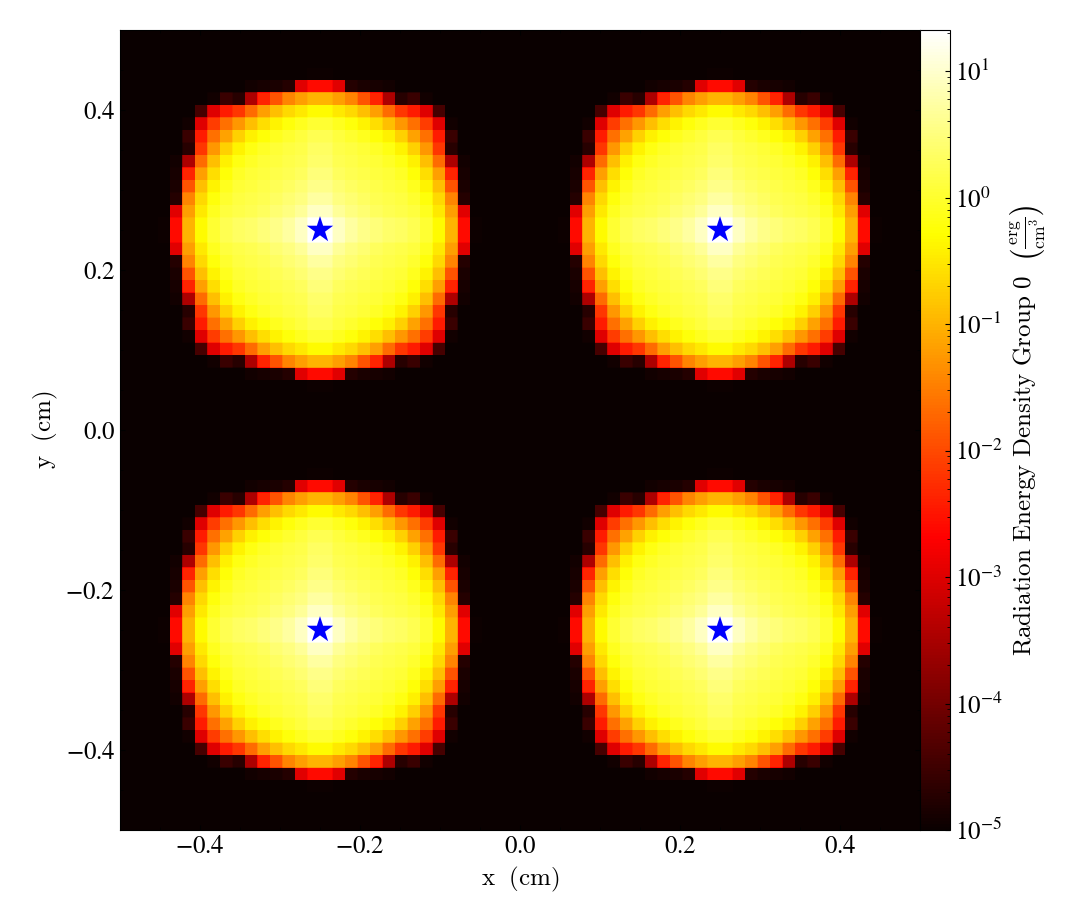

In [10]:
ds = yt.load("sample/RadiatingParticles/plt026")
yt.SlicePlot(ds, "z", ('rad', 'energy_density_0'), center='c').set_cmap(('rad', 'energy_density_0'), 'hot').annotate_particles(1, p_size=400., col='blue', marker='*', ptype='Rad_particles')

## 6. Experiments

The `metadata.yaml` is the key to determine if your dataset is a `QUOKKA` data object.    
If `metadata.yaml` is missing (e.g., data generated by some early versions of `QUOKKA` code), you may create it manually.  
Or, just simply bypass metadata parsing if you believe it is a `QUOKKA` dataset:


In [11]:
import yt
from yt.frontends.amrex.data_structures import QuokkaDataset

class OldQuokkaDataset(QuokkaDataset):
    def _parse_metadata_file(self):
        pass

ds = OldQuokkaDataset("sample/RadBeam/plt007")

yt : [INFO     ] 2025-03-15 13:10:36,748 Parameters: current_time              = 1.334256380792608e-10
yt : [INFO     ] 2025-03-15 13:10:36,749 Parameters: domain_dimensions         = [128 128   1]
yt : [INFO     ] 2025-03-15 13:10:36,749 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-15 13:10:36,751 Parameters: domain_right_edge         = [2. 2. 1.]


## 7. Debug

For debugging, you can simply set log level to `DEBUG` to check more details:

In [12]:
import yt
yt.set_log_level("DEBUG")

yt : [DEBUG    ] 2025-03-15 13:10:36,758 Set log level to DEBUG
